In [9]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [4, 4]
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [8]:
!ls ../mini_cinic10/

classes_and_names.csv
images
README.txt
test.npz
train.npz
val.npz


In [11]:
PATH_TO_DATA = os.path.join("..", "mini_cinic10")

train_data = np.load(os.path.join(PATH_TO_DATA, "train.npz"))
val_data   = np.load(os.path.join(PATH_TO_DATA, "val.npz"))
test_data  = np.load(os.path.join(PATH_TO_DATA, "test.npz"))

In [13]:
xs, ys = train_data['xs'], train_data['ys']

In [16]:
print(xs.shape) # 3072 = 3 * 1024 = 3 * (32 * 32)
xs

(80000, 3072)


array([[119,  13,   5, ...,  81,  76,  76],
       [255, 255, 255, ...,  72,  82,  69],
       [ 91,  74,  46, ..., 103,  74,  35],
       ...,
       [  1,   1,   1, ...,  45,  38,  30],
       [149, 101,  80, ..., 143, 143, 143],
       [170, 189, 195, ..., 140, 140, 132]], dtype=uint8)

In [17]:
print(ys.shape)
ys

(80000,)


array([1, 9, 6, ..., 3, 5, 0], dtype=uint8)

In [30]:
IMG_WIDTH = IMG_HEIGHT = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # RGB images

# classes_and_names.csv
CLASSES = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
CLASSES_COUNT = len(CLASSES)

In [27]:
def unravel(flat_img):
    ''' Reverts a flattened image back into a 3-layer RGB matrix representation '''
    return flat_img.reshape(IMG_SHAPE)

In [72]:
def show_image(img_index, xs, ys, figsize=None):
    ''' Shows the image represented by the array at the given img_index '''
    if figsize:
        fig = plt.figure(figsize=figsize)
    plt.imshow(unravel(xs[img_index]))
    plt.title(f'idx #{img_index} ({CLASSES[ys[img_index]]})')
    plt.axis(False)
    plt.show()

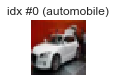

In [77]:
show_image(0, xs, ys, [1, 1])

In [ ]:
# jupyter nbconvert PreAssignment2.ipynb --to="python" --output-dir="." --output="pre-assignment2"